In [562]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [563]:
def area(x):
    if x == "Los Angeles" or x == "Anaheim" or x == "Long Beach":
        return "Los Angeles"
    elif x == "Dallas" or x == "Arlington" or x == "Fort Worth":
        return "Dallas"
    elif x == "Chicago" or x == "Engin" or x == "Naperville":
        return "Chicago"
    else:
        return "DC"
    
metro = pd.read_csv('../data/final/metro/metro_all.csv')
metro = metro.drop(["Unnamed: 0"], axis = 1)
shuffled = metro.sample(frac=1).reset_index().drop(["index"], axis = 1).drop(["dist_shopping.1"], axis = 1).drop(["Housing Price/SQ Ft"], axis = 1)
shuffled["City"] = shuffled["City"].apply(area)
shuffled = pd.get_dummies(shuffled, columns=["City"])
X = shuffled.drop("Norm Price", 1)
y = shuffled["Norm Price"]
shuffled


/var/folders/cm/_n101lcd24v_khq7567y13rm0000gn/T/ipykernel_12419/2722682471.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = shuffled.drop("Norm Price", 1)


,Norm Price,dist_hospitals,dist_gym,dist_cemetary,dist_parks,dist_beaches,dist_shopping,dist_grocery,dist_resturant,dist_golf,dist_school,City_Chicago,City_DC,City_Dallas,City_Los Angeles
0,0.363175,18016.182237,18304.781821,18309.885016,18308.245617,18250.801425,18299.239304,18229.512048,18302.586382,18266.699012,18296.979504,1,0,0,0
1,0.027939,21459.896283,21464.946402,21423.887761,21471.679801,21421.610300,21463.338106,21463.338106,21464.811644,19614.928512,21462.722838,0,0,0,1
2,0.067398,18358.310433,18354.202930,18348.855627,18349.853565,18358.674106,18351.221846,18351.367025,18343.407361,18349.297543,18342.698874,0,0,1,0
3,0.130628,18075.806573,18363.767034,18368.852925,18367.242818,18309.838325,18358.231747,18287.936567,18361.578880,18325.391356,18355.936748,0,1,0,0
4,0.015495,21448.049184,21453.084791,21412.047328,21459.847675,21409.770457,21451.479521,21451.479521,21452.949421,19600.918158,21450.859904,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3984,0.039237,21496.343464,21501.387562,21460.337697,21508.133176,21458.060480,21499.780524,21499.780524,21501.252550,19650.254048,21499.163448,0,0,0,1
3985,0.062202,18374.922756,18370.814618,18365.466996,18366.464792,18375.288106,18367.833396,18367.978588,18360.018968,18365.908437,18359.310388,0,0,1,0
3986,0.016291,21438.087707,21443.116993,21402.088764,21449.892715,21399.812151,21441.513042,21441.513042,21442.981357,19590.041434,21440.891532,0,0,0,1
3987,0.031719,21485.811793,21490.854124,21449.806839,21497.603333,21447.529694,21489.247454,21489.247454,21490.719038,19639.508109,21488.629850,0,0,0,1


[ 79.88  90.34  98.45 100.01 100.01 100.01 100.01 100.01 100.01 100.01
 100.01 100.01 100.01 100.01]


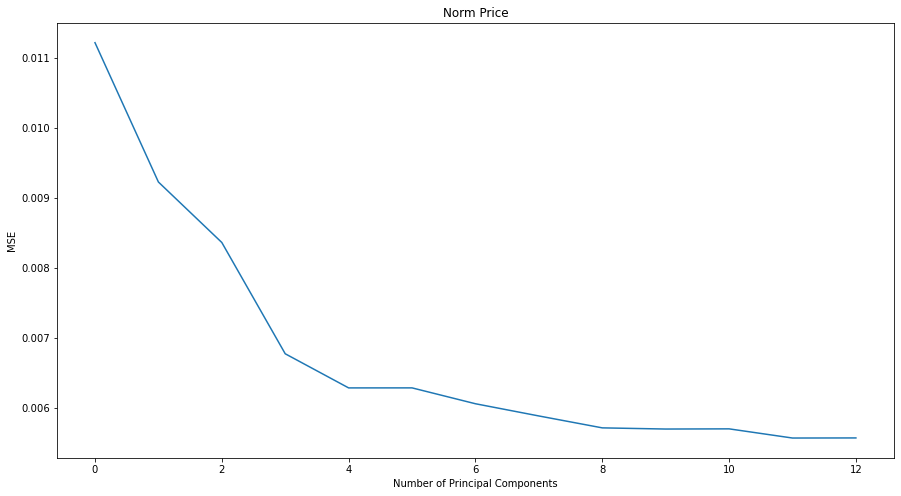

In [564]:
#scale predictor variables
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

#define cross validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept
score = -1*model_selection.cross_val_score(regr,
           np.ones((len(X_reduced),1)), y, cv=cv,
           scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 13):
    score = -1*model_selection.cross_val_score(regr,
               X_reduced[:,:i], y, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot cross-validation results    
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('Norm Price')

print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

rmse = list()
for i in range(1, 13):
    #split the dataset into training (80%) and testing (20%) sets
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0) 

    #scale the training and testing data
    X_reduced_train = pca.fit_transform(scale(X_train))
    X_reduced_test = pca.transform(scale(X_test))[:,:i]

    #train PCR model on training data 
    regr = LinearRegression()
    regr.fit(X_reduced_train[:,:i], y_train)

    #calculate RMSE
    pred = regr.predict(X_reduced_test)
    rmse.append(np.sqrt(mean_squared_error(y_test, pred)))


[0.09266737352237096,
 0.0869314280205633,
 0.0787232700307499,
 0.07612446603024318,
 0.07603172124796494,
 0.48966281580806337,
 0.6049281985587336,
 0.27697872250775124,
 0.17257368307961962,
 1.7666980093840734,
 71.59999463931328,
 83.73968269731834]

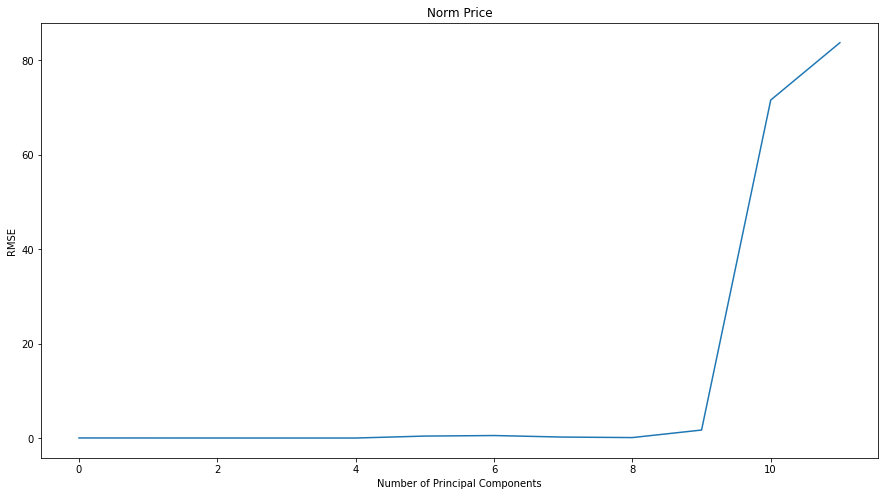

In [565]:
# Plot RMSE results    
plt.plot(rmse)
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('Norm Price')
rmse

In [568]:
abs(pca.components_)

array([[2.98359290e-01, 2.98676477e-01, 2.98695009e-01, 2.98668246e-01,
        2.98768837e-01, 2.98675691e-01, 2.98675912e-01, 2.98657018e-01,
        2.58501642e-01, 2.98662596e-01, 2.89785291e-02, 2.28957913e-01,
        3.91421000e-02, 2.75069692e-01],
       [3.43080479e-02, 3.06384635e-02, 2.71383820e-02, 3.10431489e-02,
        2.14555206e-02, 3.08837567e-02, 3.20337197e-02, 3.22005176e-02,
        3.15889046e-01, 3.19164363e-02, 2.96951978e-01, 4.81909231e-01,
        7.05565838e-01, 2.71407830e-01],
       [3.61972279e-02, 1.87335034e-03, 3.76775009e-05, 1.03021116e-03,
        6.95333942e-03, 2.21494033e-03, 1.05266438e-02, 1.15757109e-03,
        5.89636427e-02, 1.67425327e-03, 8.70775321e-01, 9.33900612e-02,
        4.75698849e-01, 4.21842441e-02],
       [5.12491791e-02, 3.61356483e-02, 4.59268294e-02, 3.74830256e-02,
        3.78629742e-02, 3.49496239e-02, 1.31974787e-02, 3.54729719e-02,
        6.88842108e-01, 3.46551778e-02, 5.21856361e-02, 5.49182765e-01,
        7.557